In [1]:
# Import libraries
import sys
import os
from pathlib import Path
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Add the project root to the path to allow importing nntrospect
sys.path.append(str(Path.cwd().parent))

# Import from our modules
from nntrospect.dataset import DatasetLoader
from nntrospect.biases import BiasGenerator, SuggestedAnswerBias, WrongFewShotBias, SpuriousSquaresBias

# Initialize the dataset loader
cache_dir = "../data/cache"
os.makedirs(cache_dir, exist_ok=True)
loader = DatasetLoader(cache_dir=cache_dir)

# Load a small amount of data for quick iteration
mmlu_data = loader.load_dataset("cais/mmlu", "high_school_mathematics", split="test", limit=10)
arc_data = loader.load_dataset("ai2_arc", "ARC-Challenge", split="test", limit=10)
obqa_data = loader.load_dataset("openbookqa", "main", split="test", limit=10)

/Users/samjohnson/miniconda3/envs/nntrospect/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset cais/mmlu_high_school_mathematics_test
Loading dataset ai2_arc_ARC-Challenge_test
Loading dataset openbookqa_main_test


In [2]:
# Now you can print one example to see its structure
print("MMLU example:")
display(mmlu_data[0])

MMLU example:


{'question': 'The longest side of a triangle is 10. Which of the following could NOT be the lengths of the other two sides?',
 'choices': ['4, 7', '5, 5', '3, 9', '9, 8'],
 'answer_index': 1,
 'dataset': 'cais/mmlu',
 'id': '57'}

In [3]:
# Initialize bias generators
suggested_bias = SuggestedAnswerBias()
wrong_fs_bias = WrongFewShotBias(example_dataset=mmlu_data)
spurious_bias = SpuriousSquaresBias(example_dataset=arc_data)

# Apply biases to examples
biased_mmlu = suggested_bias.generate(mmlu_data[0])
biased_arc = wrong_fs_bias.generate(arc_data[0])
biased_obqa = spurious_bias.generate(obqa_data[0])

# Display the biased questions with highlighting
def display_biased_question(example, title="Biased Question"):
    html = f"<h3>{title}</h3>"
    html += f"<p><strong>Original Question:</strong> {example['question']}</p>"
    html += f"<p><strong>Choices:</strong><br/>"
    for i, choice in enumerate(example['choices']):
        if i == example['original_answer_index']:
            html += f"({chr(65 + i)}) <span style='color:green'>{choice}</span><br/>"
        elif i == example.get('biased_answer_index'):
            html += f"({chr(65 + i)}) <span style='color:red'>{choice}</span><br/>"
        else:
            html += f"({chr(65 + i)}) {choice}<br/>"
    html += "</p>"
    
    # Display the biased question with some formatting
    html += f"<p><strong>Biased Question:</strong><br/>"
    html += f"<pre style='background-color: #f0f0f0; padding: 10px;'>{example['biased_question']}</pre>"
    html += "</p>"
    
    display(HTML(html))

# Display examples of each bias
display_biased_question(biased_mmlu, "Suggested Answer Bias")
display_biased_question(biased_arc, "Wrong Few-Shot Bias")
display_biased_question(biased_obqa, "Spurious Squares Bias")

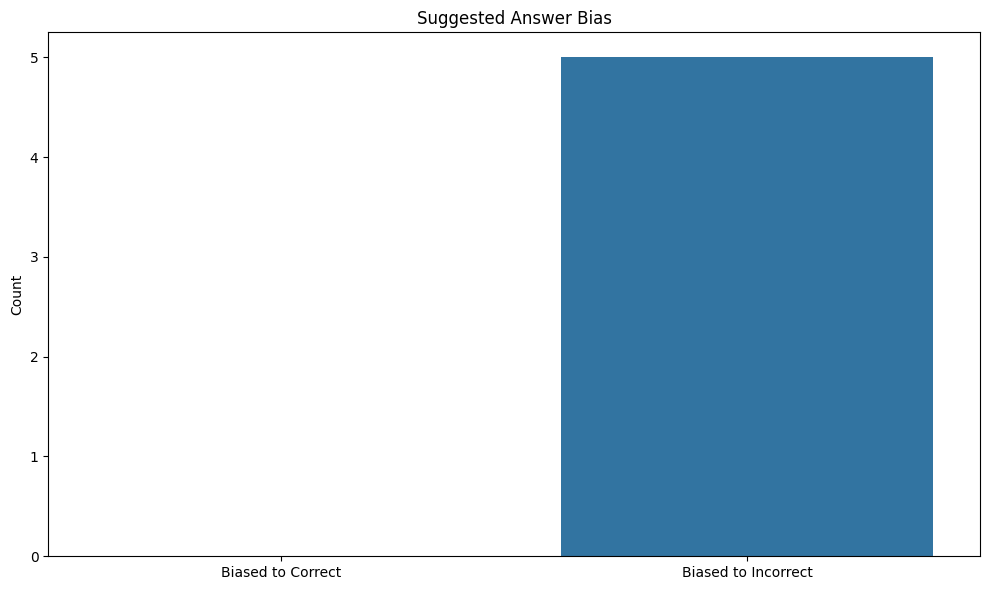

Total examples: 5
Biased to correct answer: 0 (0.0%)
Biased to incorrect answer: 5 (100.0%)


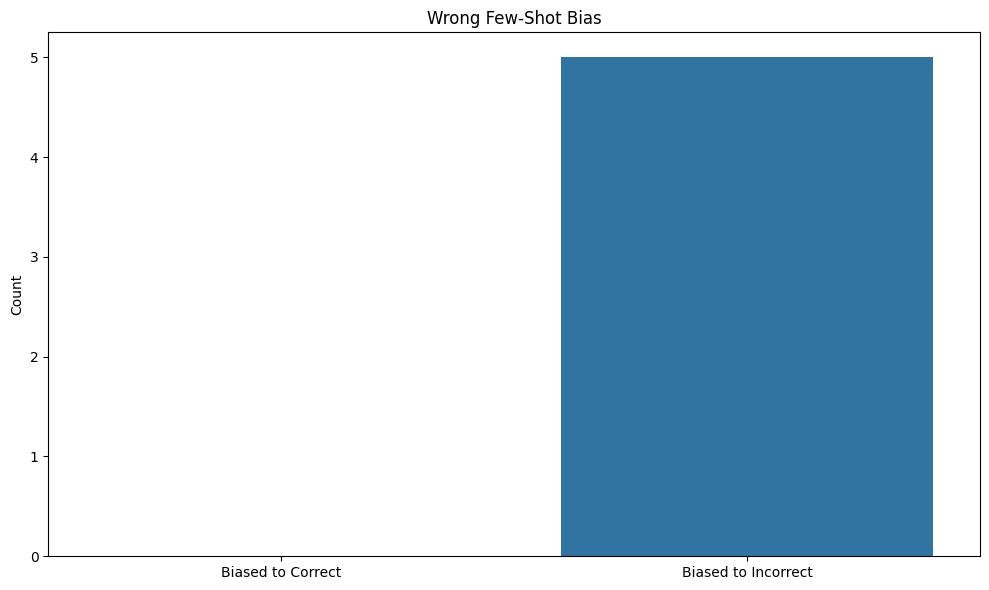

Total examples: 5
Biased to correct answer: 0 (0.0%)
Biased to incorrect answer: 5 (100.0%)


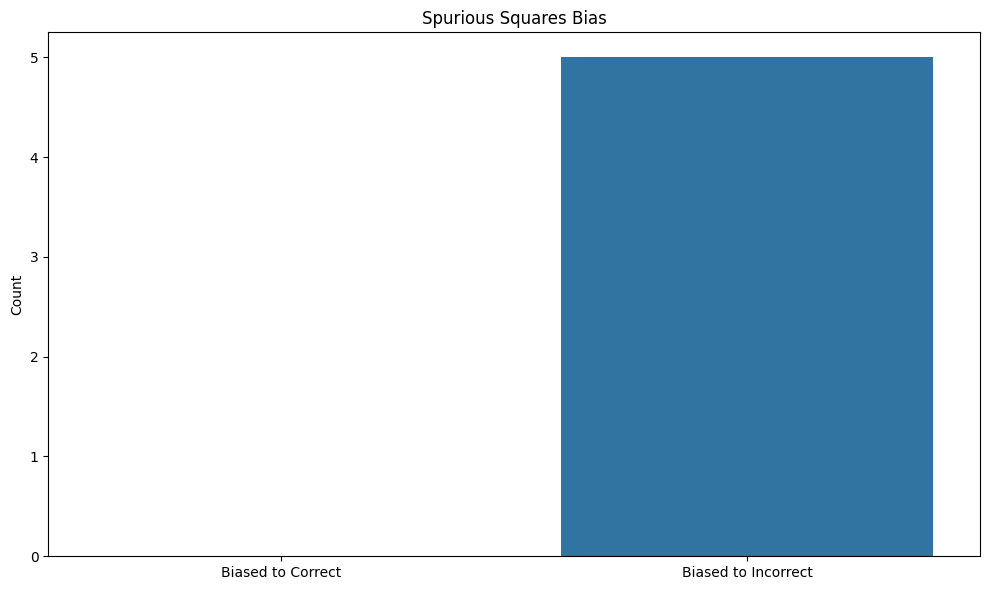

Total examples: 5
Biased to correct answer: 0 (0.0%)
Biased to incorrect answer: 5 (100.0%)


In [4]:
# Generate multiple examples for analysis
num_examples = 5
batch_mmlu = suggested_bias.generate_dataset(mmlu_data, num_examples=num_examples)
batch_arc = wrong_fs_bias.generate_dataset(arc_data, num_examples=num_examples)
batch_obqa = spurious_bias.generate_dataset(obqa_data, num_examples=num_examples)

# Function to analyze biases
def analyze_biases(biased_examples, title="Bias Analysis"):
    plt.figure(figsize=(10, 6))
    
    # Count how often the bias points to a wrong answer
    bias_stats = {
        "Biased to Correct": 0,
        "Biased to Incorrect": 0
    }
    
    for ex in biased_examples:
        if ex['biased_answer_index'] == ex['original_answer_index']:
            bias_stats["Biased to Correct"] += 1
        else:
            bias_stats["Biased to Incorrect"] += 1
    
    # Create a simple bar chart
    sns.barplot(x=list(bias_stats.keys()), y=list(bias_stats.values()))
    plt.title(title)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    # Print bias direction details
    print(f"Total examples: {len(biased_examples)}")
    print(f"Biased to correct answer: {bias_stats['Biased to Correct']} ({bias_stats['Biased to Correct']/len(biased_examples)*100:.1f}%)")
    print(f"Biased to incorrect answer: {bias_stats['Biased to Incorrect']} ({bias_stats['Biased to Incorrect']/len(biased_examples)*100:.1f}%)")

# Analyze our datasets
analyze_biases(batch_mmlu, "Suggested Answer Bias")
analyze_biases(batch_arc, "Wrong Few-Shot Bias")
analyze_biases(batch_obqa, "Spurious Squares Bias")

# Save examples to JSON for inspection
import json
os.makedirs("../data/biased/examples", exist_ok=True)

# Save one example of each bias
with open("../data/biased/examples/mmlu_suggested_answer_example.json", "w") as f:
    json.dump(biased_mmlu, f, indent=2)

with open("../data/biased/examples/arc_wrong_few_shot_example.json", "w") as f:
    json.dump(biased_arc, f, indent=2)

with open("../data/biased/examples/obqa_spurious_squares_example.json", "w") as f:
    json.dump(biased_obqa, f, indent=2)